# Random Forests

TODO:
- talk about decision trees and random forests, compare random forests to decision trees (ensemble, bagging, etc.)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# sns.set()

In [2]:
train = pd.read_csv("../data/thorax_and_wing_reduced_train.csv")
test = pd.read_csv("../data/thorax_and_wing_reduced_test.csv")

predictors = (
    list(filter(lambda c: c.startswith("Sex_"), train.columns)) +
    list(filter(lambda c: c.startswith("Population_"), train.columns)) +
    ["Temperature", "Thorax_length", "l2", "l3p", "l3d", "lpd", "l3", "w1", "w2", "w3", "wing_loading"]
)

X_train, y_train = train[predictors].to_numpy(), train["Species"].to_numpy()
X_test, y_test = test[predictors].to_numpy(), test["Species"].to_numpy()

print("Train dataset:", X_train.shape, y_train.shape)
print("Test dataset:", X_test.shape, y_test.shape)

Train dataset: (1211, 18) (1211,)
Test dataset: (519, 18) (519,)


## Hyperparameter Selection

There are two important hyperparameters for a random forest that we consider - the number of trees in the forest, and the maximum depth of each tree.

For the first, it can be shown that more ensemble members only reduces the model variance* but does not increase the model flexibility. This means that a larger number of trees does not lead to overfitting, so the only reason for choosing a small number of trees would be due to computational cost. For this reason, we chose 128 trees as the computation times were reasonable for this selection.

For the second (maximum depth), we can use cross-validation to select the optimal value. By default in sklearn, the max depth is not limited and all leaves will be expanded until they're pure or only contain one node. This can lead to massive trees both in terms of size and complexity, which is likely to lead to overfitting, so the max depth should be controlled.

*the model variance is eventually limited by the average correlation between the trees, at which point it plateaus.

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

parameters = {"max_depth": range(1, 30)}

forest = RandomForestClassifier(n_estimators=200, random_state=42)
clf = GridSearchCV(forest, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(n_estimators=200,
                                              random_state=42),
             param_grid={'max_depth': range(1, 30)})

Doing a grid search CV shows that the optimal max depth to set is 14:

In [4]:
print("Best params       :", clf.best_params_)
print("Best mean CV score:", clf.best_score_)

Best params       : {'max_depth': 14}
Best mean CV score: 0.800153045607591


In [5]:
from sklearn.metrics import accuracy_score

forest = RandomForestClassifier(n_estimators=200, max_depth=14, random_state=42)
forest.fit(X_train, y_train)
train_preds = forest.predict(X_train)
test_preds = forest.predict(X_test)
print("Training accuracy:", accuracy_score(y_train, train_preds))
print("Test accuracy    :", accuracy_score(y_test, test_preds))

Training accuracy: 0.9983484723369116
Test accuracy    : 0.791907514450867


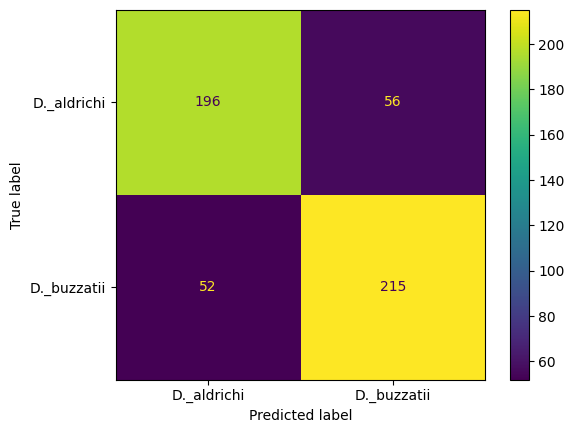

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, test_preds, labels=forest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=forest.classes_)
disp.plot()
plt.show()